## 1 - Vérification de la distribution des critical events dans les différents sets
## 2 - Choix de la méthode d'interpolation

L'idée est de visualiser la répartition des critical events dans chacun des sets, car une répartition inhomogène aura forcément un impact sur les résultats du machine learning, et de choisir une méthode d'interpolation convenable pour les données de speed_network, accélérations et gyro.

In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
# keep all the visualizations into the notebook file :
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
bag = glob.glob('datasets_bag/*.csv')

### 1er test : lecture normale des fichiers et split ratio 80:20 pour le train:test

In [3]:
df_list1 = []

for minifile in bag:
    df = pd.read_csv(minifile)
    df_list1.append(df)
df0 = pd.concat(df_list1)

In [3]:
# df_list1 = []
# df_list2 = []

# for minifile in bag:
#     df = pd.read_csv(minifile)
#     df_list1.append(df)
# df1 = pd.concat(df_list1)

# np.random.shuffle(bag)

# for minifile in bag:
#     df = pd.read_csv(minifile)
#     df_list2.append(df)
# df2 = pd.concat(df_list2)

# df0 = pd.concat([df1, df2])

En doublant la taille du dataframe en le dupliquant, on s'expose probablement à un overfitting donc on laisse tomber cette idée (haut).
En tentant cette méthode, le modèle semblait overfitter (excellents train et validation scores, horrible test score)

In [4]:
len(df0)

389709

In [5]:
df0['target_critical_event'].value_counts()

0    389695
1        14
Name: target_critical_event, dtype: int64

In [6]:
df0.drop(columns=['Unnamed: 0'], inplace=True)
df0.drop(columns=['vtti.latitude', 'vtti.longitude', 'vtti.speed_gps', 'vtti.cruise_state'], inplace=True)
df0.drop(columns=['vtti.timestamp'], inplace=True)
df0.reset_index(drop=True, inplace=True)
df0

,vtti.file_id,vtti.accel_x,vtti.accel_y,vtti.accel_z,vtti.gyro_x,vtti.gyro_y,vtti.gyro_z,vtti.speed_network,target_critical_event
0,2790-1,0.0174,-0.020300,-0.983100,0.000000,-0.325195,0.000000,0.921875,0
1,2790-1,-0.0087,-0.020300,-0.983100,0.000000,-0.325195,0.000000,1.062500,0
2,2790-1,-0.0145,-0.023200,-0.986000,0.000000,-0.325195,0.000000,1.140625,0
3,2790-1,-0.0145,-0.020300,-0.986000,0.000000,0.000000,0.000000,1.203125,0
4,2790-1,-0.0145,-0.017400,-0.980200,0.000000,-0.325195,0.000000,1.281250,0
...,...,...,...,...,...,...,...,...,...
389704,4232-0,-0.1515,-0.081200,-0.997600,-0.325195,0.325195,0.000000,3.062500,0
389705,4232-0,-0.1602,-0.078300,-1.006300,-0.650391,0.000000,0.000000,2.437500,0
389706,4232-0,-0.1689,-0.069600,-1.003400,-0.325195,0.000000,0.000000,1.953125,0
389707,4232-0,-0.1747,-0.069600,-1.000500,-0.325195,0.000000,-0.325195,1.359375,0


In [7]:
# indice de tous les event=1 (avant labellisation)
list_index = df0[df0['target_critical_event'] == 1].index

# labellisation
def ext_target(df_target, list_index, task='classification'):
    df = df_target.copy()
    
    if task=='classification':
        if list_index[0] >29 :
            df.loc[list_index[0]-29:list_index[0],'target_critical_event']=1
        else : 
            df.loc[0:list_index[0],'target_critical_event']=1

        for i in range(len(list_index)-1) :
            if list_index[i+1]-list_index[i]>30:
                df.loc[list_index[i+1]-29:list_index[i+1],'target_critical_event']=1
            else : 
                df.loc[list_index[i]:list_index[i+1],'target_critical_event']=1
                
    else :  # regression
        if list_index[0] >29 :
            df.loc[list_index[0]-29:list_index[0],'target_critical_event']=[np.exp(-x/8) for x in range(29,-1,-1)]
        else : 
            df.loc[0:list_index[0],'target_critical_event']=[np.exp(-x/8) for x in range(list_index[0],-1,-1)]

        for i in range(len(list_index)-1) :
            delta=list_index[i+1]-list_index[i]
            if delta > 30:
                df.loc[list_index[i+1]-29:list_index[i+1],'target_critical_event']=[np.exp(-x/8) for x in range(29,-1,-1)]
            else : 
                df.loc[list_index[i]+1:list_index[i+1],'target_critical_event']=[np.exp(-x/8) for x in range(delta-1,-1,-1)]
    return (df)

In [8]:
try:
    df_class, df_reg = ext_target(df0, list_index), \
                        ext_target(df0, list_index, task='regression')
except:
    print("no critical event")

In [9]:
df_class = df_class.loc[set(range(len(df0)))-set(list_index),:]
df_reg = df_reg.loc[set(range(len(df0)))-set(list_index),:]

In [10]:
df_class['target_critical_event'].value_counts()

0    389291
1       404
Name: target_critical_event, dtype: int64

In [12]:
# Test - Découpe non aléatoire en raison des dépendances avec le temps en 80:20 

df_test = df_class.copy()
df_test_reg = df_reg.copy()

x = df_test.drop(columns='target_critical_event')
y = df_test['target_critical_event']

x_train, y_train = x[:(4*len(x))//5], y[:(4*len(x))//5]
x_test, y_test = x[(4*len(x))//5:], y[(4*len(x))//5:]

In [13]:
def viz_dist_train_test(col, name, \
                        x_train, \
                        y_train, \
                        x_test, \
                        y_test, \
                        title_1 = 'Distribution for the Train Set', title_2 = 'Distribution for the Test Set', num_type=True) :
    if x_train.shape == x_test.shape : #Permet d'utiliser la même fonction selon que l'on découpe le set en train/test ou non 
        plt.figure()
        g = sns.kdeplot(x_train[col][(y_train == 0)], color="Red", shade=True)
        g = sns.kdeplot(x_train[col][(y_train == 1)], ax=g, color="Blue", shade=True)
        g.set_xlabel(name)
        g.set_ylabel("Frequency")
        g.set_title(title_1)
        g = g.legend(["No Critical Event","Critical Event"])
        plt.show()
    else : 
        plt.subplots(1,2,figsize=(15,5))
        plt.subplot(1,2,1)
        g = sns.kdeplot(x_train[col][(y_train == 0)], color="Red", shade = True)
        g = sns.kdeplot(x_train[col][(y_train == 1)], ax =g, color="Blue", shade= True)
        g.set_xlabel(name)
        g.set_ylabel("Frequency")
        g.set_title(title_1)
        g = g.legend(["No Critical Event","Critical Event"])
        plt.subplot(1,2,2)
        g = sns.kdeplot(x_test[col][(y_test == 0)], color="Red", shade = True)
        g = sns.kdeplot(x_test[col][(y_test == 1)], ax =g, color="Blue", shade= True)
        g.set_xlabel(name)
        g.set_ylabel("Frequency")
        g.set_title(title_2)
        g = g.legend(["No Critical Event","Critical Event"])
        plt.show()

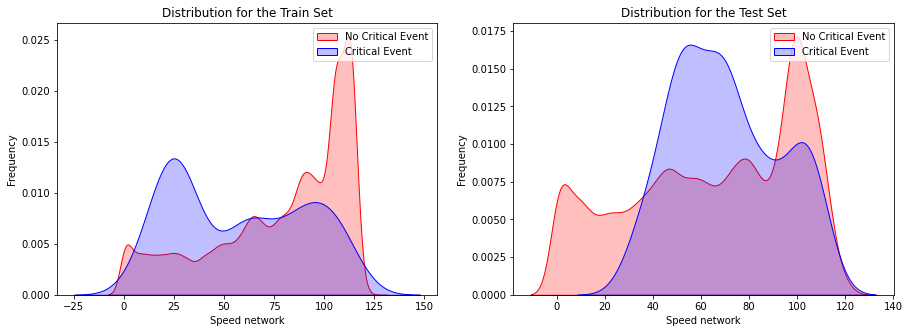

In [14]:
# Distribution of the train and test datasets (!!! linear interpolation of speed_network done in Dataset_Cleaner)
viz_dist_train_test('vtti.speed_network', 'Speed network', x_train, y_train, x_test, y_test)

Observation : Distributions des critical events trop differentes entre train (80% des premiers fichiers du dataset) et test (20%)

### 2eme test : répartition des fichiers selon un split ratio 75:15 (train:test) puis 75:15 (train:val) sans les critical_target=1, puis distribution à peu près équitable de ces critical_target=1 dans chacun des sets

Vérifier combien de critical_target_event=1 il y a dans chaque fichier et les répartir assez équitablement dans chacun des sets

In [16]:
# Check la liste des files qui contiennent au moins un critical_event=1
# y en a que 7 sur 83
# répartir ces fichiers-là équitablement dans les train-test-validation sets pour que chacun en ait autant
# donc dans un premier temps, on les répartis dans des fichiers préliminaires, qui seront destinés
# à être mis ensuite dans les train-val-test finaux une fois que ces derniers soient splités selon un certain ratio
# NB : à améliorer car il y a parfois les fichiers ayant le plus de critical_event=1 qui se retrouvent dans le val ou le test
# -> il faut pour le moment exécuter plusieurs jusqu'à ce qu'on obtienne une répartition qui nous parait assez juste

np.random.shuffle(bag)
goto_train = []
goto_val = []
goto_test = []
count = 0

for minifile in bag:
    df = pd.read_csv(minifile)
    #print(df['target_critical_event'].value_counts())
    #print("\n")
    if (1 in df['target_critical_event'].values):
        print(minifile)
        print(df['target_critical_event'].value_counts())
        count += 1
        if count<=3:
            goto_train.append(minifile)
        if (count>3 and count<6):
            goto_val.append(minifile)
        if count>=6:
            goto_test.append(minifile)

print("--------POUR LE TRAIN :")
print(goto_train)
print("--------POUR LE VAL :")
print(goto_val)
print("--------POUR LE TEST :")
print(goto_test)

datasets_bag\3380-0.csv
0    42978
1        1
Name: target_critical_event, dtype: int64
datasets_bag\3108-0.csv
0    22354
1        1
Name: target_critical_event, dtype: int64
datasets_bag\4208-2.csv
0    12299
1        5
Name: target_critical_event, dtype: int64
datasets_bag\3014-2.csv
0    14231
1        1
Name: target_critical_event, dtype: int64
datasets_bag\3562-3.csv
0    9172
1       3
Name: target_critical_event, dtype: int64
datasets_bag\3342-3.csv
0    9412
1       1
Name: target_critical_event, dtype: int64
datasets_bag\4232-0.csv
0    22585
1        2
Name: target_critical_event, dtype: int64
--------POUR LE TRAIN :
['datasets_bag\\3380-0.csv', 'datasets_bag\\3108-0.csv', 'datasets_bag\\4208-2.csv']
--------POUR LE VAL :
['datasets_bag\\3014-2.csv', 'datasets_bag\\3562-3.csv']
--------POUR LE TEST :
['datasets_bag\\3342-3.csv', 'datasets_bag\\4232-0.csv']


In [17]:
#bag_without_critical_event = set(bag) - set(goto_train) - set(goto_val) - set(goto_test)  # can't use 'set' here..
bag_critical = goto_train + goto_val + goto_test
bag_without_critical_event = [file for file in bag if file not in bag_critical]
len(bag_without_critical_event)

76

In [18]:
train_bag0, test_bag0 = train_test_split(bag_without_critical_event, test_size=0.15, random_state=42)
train_bag0, val_bag0 = train_test_split(train_bag0, test_size=0.15, random_state=42)

print(len(train_bag0))
print(len(val_bag0))
print(len(test_bag0))

54
10
12


In [19]:
# une fois le dataset ayant été splité, on attribue à chacun des sets leur portion de critical events

train_bag = train_bag0 + goto_train
val_bag = val_bag0 + goto_val
test_bag = test_bag0 + goto_test

np.random.shuffle(train_bag)
np.random.shuffle(val_bag)
np.random.shuffle(test_bag)

print(len(train_bag))
print(len(val_bag))
print(len(test_bag))

57
12
14


In [20]:
# lectures des fichiers et création des dataframes pour chacun des sets

def readfiles(bag):
    df_list = []
    for minifile in bag:
            df = pd.read_csv(minifile)
            df_list.append(df)
    df0 = pd.concat(df_list)
    return df0
    
    
df0_train = readfiles(train_bag)
df0_val = readfiles(val_bag)
df0_test = readfiles(test_bag)

print(len(df0_train))
print(len(df0_val))
print(len(df0_test))

273178
54881
61650


In [ ]:
# DISTRIBUTION CHECK

In [21]:
df0_train.drop(columns=['Unnamed: 0'], inplace=True)
df0_train.reset_index(drop=True, inplace=True)
df0_train

,vtti.timestamp,vtti.file_id,vtti.accel_x,vtti.accel_y,vtti.accel_z,vtti.cruise_state,vtti.gyro_x,vtti.gyro_y,vtti.gyro_z,vtti.latitude,vtti.longitude,vtti.speed_gps,vtti.speed_network,target_critical_event
0,2000.0,3380-0,-0.0152,0.020300,-0.980200,0.0,0.000000,0.000000,-0.325195,,,,1.312500,0
1,2100.0,3380-0,-0.0152,0.017400,-0.983100,0.0,0.000000,0.000000,-0.325195,,,,1.062500,0
2,2200.0,3380-0,-0.0152,0.020300,-0.980200,0.0,,,,,,,0.906250,0
3,2300.0,3380-0,-0.0152,0.020300,-0.983100,0.0,0.000000,0.000000,0.000000,,,,0.687500,0
4,2400.0,3380-0,-0.0152,0.023200,-0.983100,0.0,0.000000,0.000000,0.000000,,,,0.468750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273173,128300.0,3310-0,-0.0783,0.017400,-0.988900,0.0,0.000000,0.000000,0.000000,,,,1.671875,0
273174,128400.0,3310-0,-0.0754,0.000000,-0.988900,0.0,0.000000,0.000000,0.000000,,,,1.242188,0
273175,128500.0,3310-0,-0.0754,0.000000,-0.994700,0.0,0.000000,-0.325195,0.000000,,,,0.812500,0
273176,128600.0,3310-0,-0.0696,0.005800,-0.997600,0.0,0.000000,0.000000,0.000000,,,,0.437500,0


In [22]:
df0_test.drop(columns=['Unnamed: 0'], inplace=True)
df0_test.reset_index(drop=True, inplace=True)
df0_test

,vtti.timestamp,vtti.file_id,vtti.accel_x,vtti.accel_y,vtti.accel_z,vtti.cruise_state,vtti.gyro_x,vtti.gyro_y,vtti.gyro_z,vtti.latitude,vtti.longitude,vtti.speed_gps,vtti.speed_network,target_critical_event
0,125900.0,3989-0,0.0261,0.002900,-0.986000,,0.000000,0.000000,-0.650391,,,,1.046875,0
1,126000.0,3989-0,0.0290,0.011600,-0.983100,,0.000000,0.000000,-0.975586,,,,1.234375,0
2,126100.0,3989-0,0.0348,0.011600,-0.986000,,0.000000,0.000000,-0.650391,,,,1.437500,0
3,126200.0,3989-0,0.0435,0.014500,-0.986000,,,,,,,,1.640625,0
4,126300.0,3989-0,0.0493,0.017400,-0.983100,,0.000000,0.000000,-0.650391,,,,1.828125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61645,451500.0,3130-2,-0.1225,0.026100,-0.997600,0.0,0.000000,0.000000,0.000000,,,,2.265625,0
61646,451600.0,3130-2,-0.1254,0.023200,-1.006300,0.0,0.000000,0.000000,0.000000,,,,1.765625,0
61647,451700.0,3130-2,-0.1225,0.023200,-1.000500,0.0,0.000000,0.000000,0.000000,,,,1.320312,0
61648,451800.0,3130-2,-0.1196,0.023200,-1.000500,0.0,,,,,,,0.875000,0


In [23]:
# indice de tous les event=1 (avant labellisation)
list_index_train = df0_train[df0_train['target_critical_event'] == 1].index
list_index_test = df0_test[df0_test['target_critical_event'] == 1].index

print(list_index_train)
print(list_index_test)

Int64Index([18791, 53758, 190290, 190810, 190838, 192764, 193364], dtype='int64')
Int64Index([12447, 14261, 54834], dtype='int64')


In [24]:
# labellisation
def ext_target(df_target, list_index, task='classification'):
    df = df_target.copy()
    
    if task=='classification':
        if list_index[0] >29 :
            df.loc[list_index[0]-29:list_index[0],'target_critical_event']=1
        else : 
            df.loc[0:list_index[0],'target_critical_event']=1

        for i in range(len(list_index)-1) :
            if list_index[i+1]-list_index[i]>30:
                df.loc[list_index[i+1]-29:list_index[i+1],'target_critical_event']=1
            else : 
                df.loc[list_index[i]:list_index[i+1],'target_critical_event']=1
                
    else :  # regression
        if list_index[0] >29 :
            df.loc[list_index[0]-29:list_index[0],'target_critical_event']=[np.exp(-x/8) for x in range(29,-1,-1)]
        else : 
            df.loc[0:list_index[0],'target_critical_event']=[np.exp(-x/8) for x in range(list_index[0],-1,-1)]

        for i in range(len(list_index)-1) :
            delta=list_index[i+1]-list_index[i]
            if delta > 30:
                df.loc[list_index[i+1]-29:list_index[i+1],'target_critical_event']=[np.exp(-x/8) for x in range(29,-1,-1)]
            else : 
                df.loc[list_index[i]+1:list_index[i+1],'target_critical_event']=[np.exp(-x/8) for x in range(delta-1,-1,-1)]
    return (df)

In [25]:
try:
    df_class_train, df_reg_train = ext_target(df0_train, list_index_train), ext_target(df0_train, list_index_train, task='regression')
    df_class_test, df_reg_test = ext_target(df0_test, list_index_test), ext_target(df0_test, list_index_test, task='regression')
except:
    print("no critical event")

In [26]:
df_class_train = df_class_train.loc[set(range(len(df0_train)))-set(list_index_train), :]
df_reg_train = df_reg_train.loc[set(range(len(df0_train)))-set(list_index_train), :]

df_class_test = df_class_test.loc[set(range(len(df0_test)))-set(list_index_test), :]
df_reg_test = df_reg_test.loc[set(range(len(df0_test)))-set(list_index_test), :]

In [27]:
df_class_train['target_critical_event'].value_counts()

0    272970
1       201
Name: target_critical_event, dtype: int64

In [28]:
df_class_test['target_critical_event'].value_counts()

0    61560
1       87
Name: target_critical_event, dtype: int64

In [29]:
# Distribution train et test

x_train = df_class_train.drop(columns='target_critical_event')
y_train = df_class_train['target_critical_event']
x_test = df_class_test.drop(columns='target_critical_event')
y_test = df_class_test['target_critical_event']

In [30]:
def viz_dist_train_test(col, name, \
                        x_train, \
                        y_train, \
                        x_test, \
                        y_test, \
                        title_1 = 'Distribution for the Train Set', title_2 = 'Distribution for the Test Set', num_type=True) :
    if x_train.shape == x_test.shape : #Permet d'utiliser la même fonction selon que l'on découpe le set en train/test ou non 
        plt.figure()
        g = sns.kdeplot(x_train[col][(y_train == 0)], color="Red", shade=True)
        g = sns.kdeplot(x_train[col][(y_train == 1)], ax=g, color="Blue", shade=True)
        g.set_xlabel(name)
        g.set_ylabel("Frequency")
        g.set_title(title_1)
        g = g.legend(["No Critical Event","Critical Event"])
        plt.show()
    else : 
        plt.subplots(1,2,figsize=(15,5))
        plt.subplot(1,2,1)
        g = sns.kdeplot(x_train[col][(y_train == 0)], color="Red", shade = True)
        g = sns.kdeplot(x_train[col][(y_train == 1)], ax =g, color="Blue", shade= True)
        g.set_xlabel(name)
        g.set_ylabel("Frequency")
        g.set_title(title_1)
        g = g.legend(["No Critical Event","Critical Event"])
        plt.subplot(1,2,2)
        g = sns.kdeplot(x_test[col][(y_test == 0)], color="Red", shade = True)
        g = sns.kdeplot(x_test[col][(y_test == 1)], ax =g, color="Blue", shade= True)
        g.set_xlabel(name)
        g.set_ylabel("Frequency")
        g.set_title(title_2)
        g = g.legend(["No Critical Event","Critical Event"])
        plt.show()

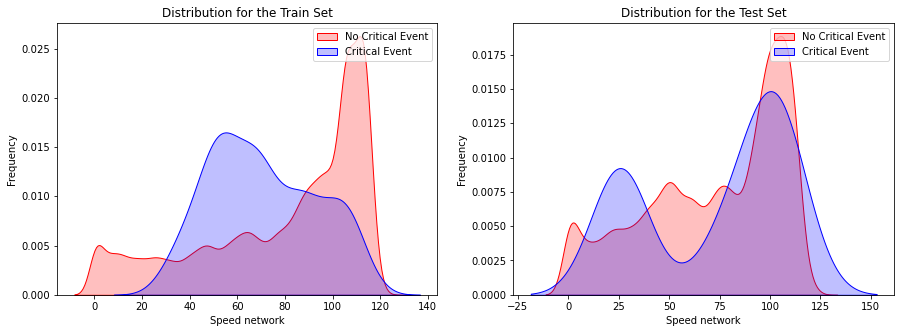

In [31]:
# Distribution of the train and test datasets (!!! linear interpolation of speed_network done in Dataset_Cleaner)
viz_dist_train_test('vtti.speed_network', 'Speed network', x_train, y_train, x_test, y_test)

Conclusion :
Même en s'arrangeant à bien répartir les critical_event=1 dans chacun des sets de façon assez équitable, et même en shufflant la répartition des fichiers de sorte que les sets n'aient pas les mêmes fichiers en réitérant l'expérience, les train et test sets finissent avec des distributions différentes. 
Je pense qu'il n'y a pas grand chose à faire, et que seul le fait d'avoir davantage de données pourrait peut-être palier à ce problème.

###  Quel degré d'interpolation choisir pour interpoler vitesses et accélérations manquantes ?

In [11]:
dfc = df_class.copy()
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389695 entries, 0 to 389708
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   vtti.file_id           389695 non-null  object 
 1   vtti.accel_x           388837 non-null  float64
 2   vtti.accel_y           389695 non-null  object 
 3   vtti.accel_z           389695 non-null  object 
 4   vtti.gyro_x            389695 non-null  object 
 5   vtti.gyro_y            389695 non-null  object 
 6   vtti.gyro_z            389695 non-null  object 
 7   vtti.speed_network     389695 non-null  float64
 8   target_critical_event  389695 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 29.7+ MB


In [13]:
# convert objects into floats and '' (missing values) into NaN

col_concerned = ['vtti.accel_x', 'vtti.accel_y', 'vtti.accel_z', \
                 'vtti.gyro_x', 'vtti.gyro_y', 'vtti.gyro_z']
for col in dfc.columns:
    if col in col_concerned:
        dfc[col] = pd.to_numeric(dfc[col], downcast='float', errors='coerce')     

In [14]:
# check how many NaN in each column
for col in dfc.columns:
    print(f'{col}, {dfc[str(col)].isna().sum()}')

vtti.file_id, 0
vtti.accel_x, 858
vtti.accel_y, 858
vtti.accel_z, 858
vtti.gyro_x, 38516
vtti.gyro_y, 38516
vtti.gyro_z, 38526
vtti.speed_network, 0
target_critical_event, 0


<AxesSubplot:>

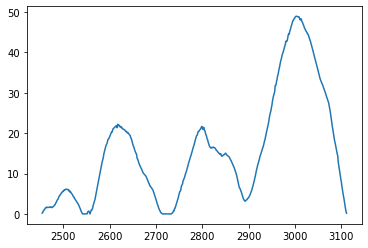

In [15]:
# Sélectionne l'un des fichiers au pif
dfc.loc[dfc['vtti.file_id'] == '2797-1']['vtti.speed_network'].plot.line()

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.05596e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.73358e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.82412e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.79065e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


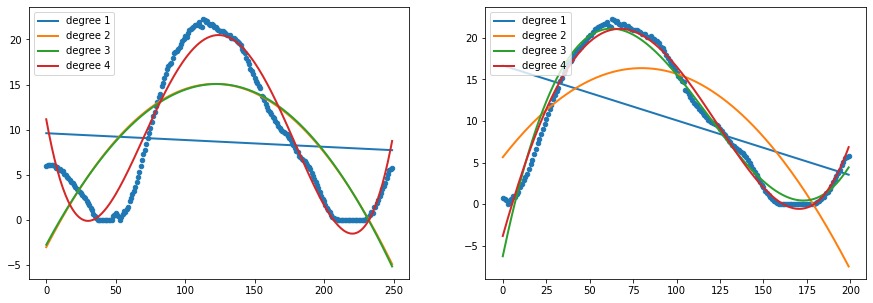

In [17]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
X = np.array(range(len(df.loc[dfc['vtti.file_id'] == '2797-1'][50:300].index))).reshape(-1,1)
y = dfc.loc[dfc['vtti.file_id'] == '2797-1']['vtti.speed_network'][50:300]
models = []
for count, degree in enumerate([1, 2, 3, 4]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.001))
    model.fit(X, y)
    models.append(model)
    y_pred = model.predict(X)
    plt.plot(X, y_pred, linewidth=2, label='degree %d' % degree)
plt.legend(loc='upper left')
plt.scatter(X, y, s=20, marker='o', label='training points')

plt.subplot(1,2,2)
X = np.array(range(len(dfc.loc[dfc['vtti.file_id'] == '2797-1'][100:300].index))).reshape(-1,1)
y = dfc.loc[dfc['vtti.file_id'] == '2797-1']['vtti.speed_network'][100:300]
models = []
for count, degree in enumerate([1, 2, 3, 4]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.001))
    model.fit(X, y)
    models.append(model)
    y_pred = model.predict(X)
    plt.plot(X, y_pred, linewidth=2, label='degree %d' % degree)
plt.legend(loc='upper left')
plt.scatter(X, y, s=20, marker='o', label='training points')
plt.show()

Observation : le polynôme de degré 3 semble bien convenir, ssi on interpole une plage de données manquantes qui n'est pas trop élevée (genre moins de 200 secondes).
Au-delà de 200 secondes de données manquantes, le degré 3 donne n'importe quoi et il vaudrait mieux passer à un degré 4, bien que ce ne soit pas non plus le meilleur.
Dans le Dataset_Cleaner on avait supprimé les zéros et données manquantes supérieurs à 180 sec, on estime donc qu'il n'y a plus de valeurs manquantes supérieures à 200 sec ici. Donc on peut garder l'interpolation de degré 3. On prendra un Cubic Spline interpolation.